## Harnessing Deep Learning for Stock Market Predictions: A CNN Approach
reproduzido e adaptado por kamilyassis, adriel1ft e biabcaval


(redes neurais convulacionais)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime #manipulação de tempo (time manipulation)
from sklearn import preprocessing #funções de analise de dados (func fr data analysis)
from operator import itemgetter #ordenação e extração de elementos (sort and extraction)
from sklearn.metrics import mean_squared_error
import keras #facilitador de deep learning integrado a outras bibliotecas (high-level API)
import seaborn as sns
sns.set() #garante a padronização dos graficos (standardization)

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/NYSE-STOCK_MARKET-ANALYSIS-USING-LSTM/master/nyse/prices-split-adjusted.csv", index_col = 0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [20]:
#movendo a coluna 'close' para o final (moving close to the last column)

df["adj close"] = df.close
#df.drop(['close'], 1, inplace=True) #não é compativel com a attz do pandas (update incompatible)
df.pop('close')
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [18]:
df2 = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/NYSE-STOCK_MARKET-ANALYSIS-USING-LSTM/master/nyse/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [21]:
#mantendo apenas os valores unicos (removing duplicate)

#symbols_t = list(df.symbol.unique()) #forma pensada (by reseacher)

#forma usada pelo autor
symbols = list(set(df.symbol))
print(len(symbols))

501


In [24]:
#vizualização (first 11 elements)
#valores não compativeis com o artigo
#esperado: ['ES', 'NLSN', 'PNW', 'SYY', 'NTRS', 'MTB', 'HP', 'DPS', 'NFLX', 'MON', 'MUR']
#recebido: ['FIS', 'ACN', 'BBBY', 'LEG', 'VRSK', 'GILD', 'MUR', 'K', 'LYB', 'ALL', 'OKE']

print(symbols[:11])

['FIS', 'ACN', 'BBBY', 'LEG', 'VRSK', 'GILD', 'MUR', 'K', 'LYB', 'ALL', 'OKE']


In [31]:
#filtrando e removendo (select and drop)
df = df[df.symbol == 'GOOG']

#df.drop(['symbol'],1,inplace=True) #não é compativel com a attz do pandas (update incompatible)

df.pop('symbol')
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1762 non-null   float64
 1   low        1762 non-null   float64
 2   high       1762 non-null   float64
 3   volume     1762 non-null   float64
 4   adj close  1762 non-null   float64
dtypes: float64(5)
memory usage: 147.1+ KB


<ipython-input-33-12eef30c07a8>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


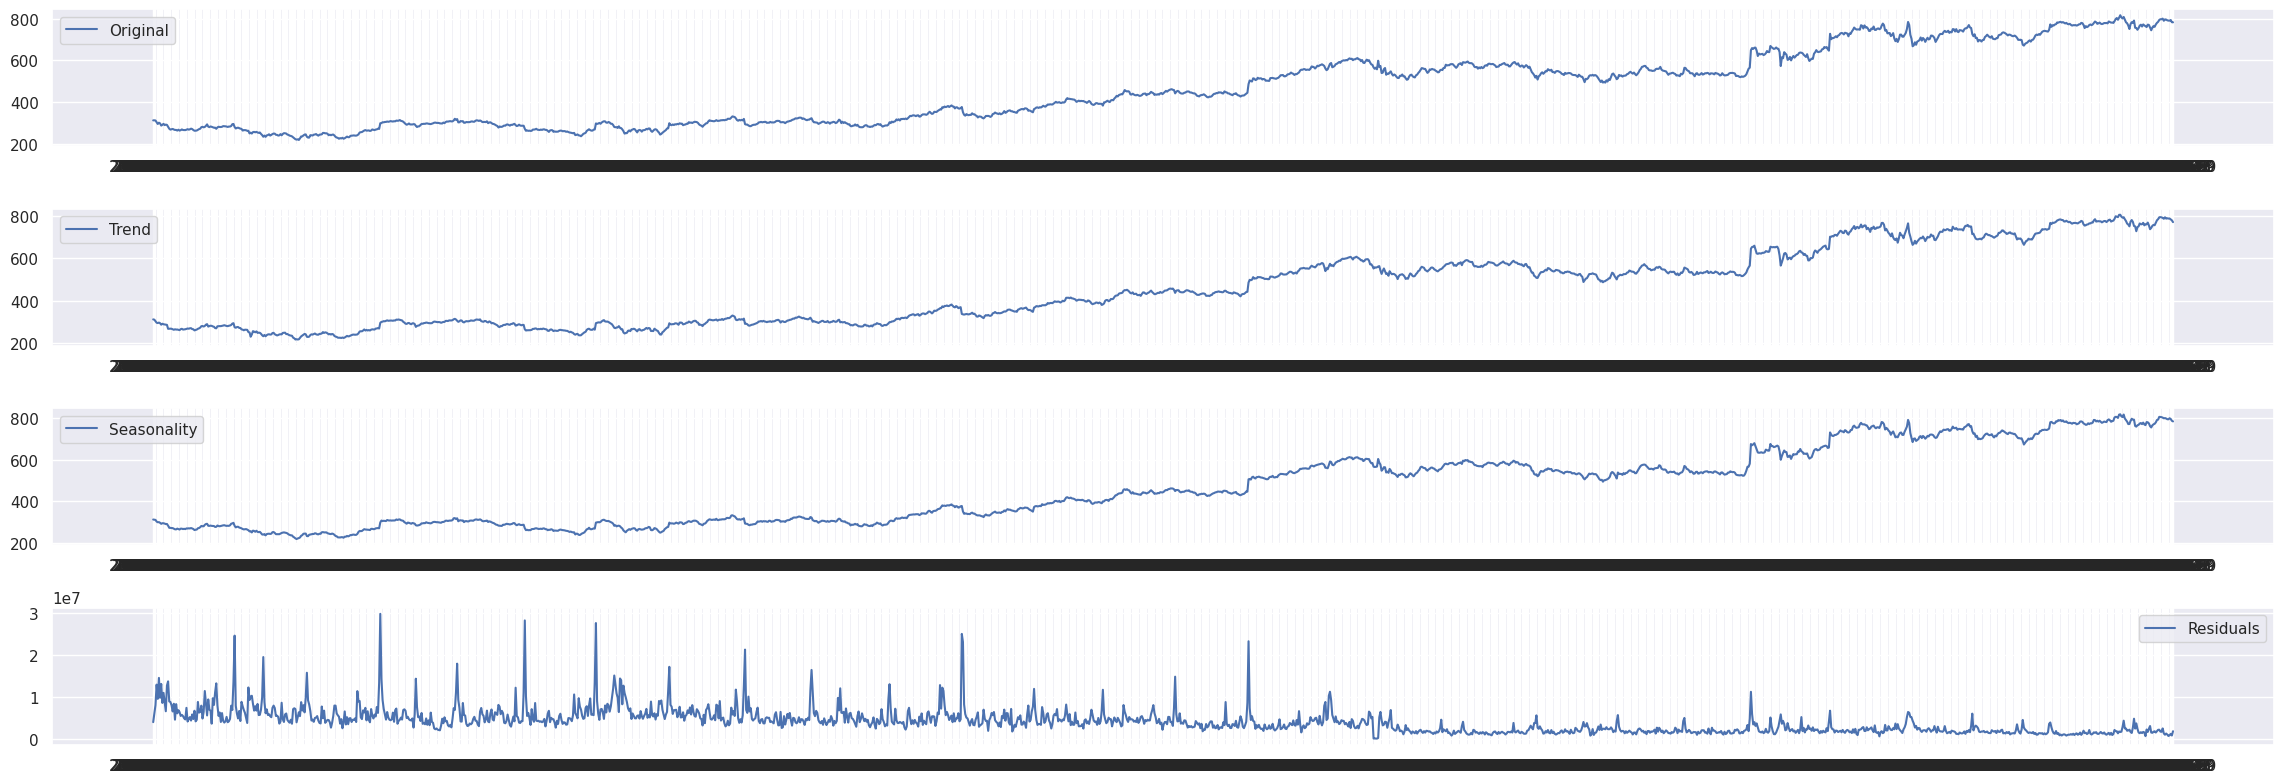

In [33]:
#plot

df.plot(figsize=(23,8),title = "Google Stock Price Analysis")
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

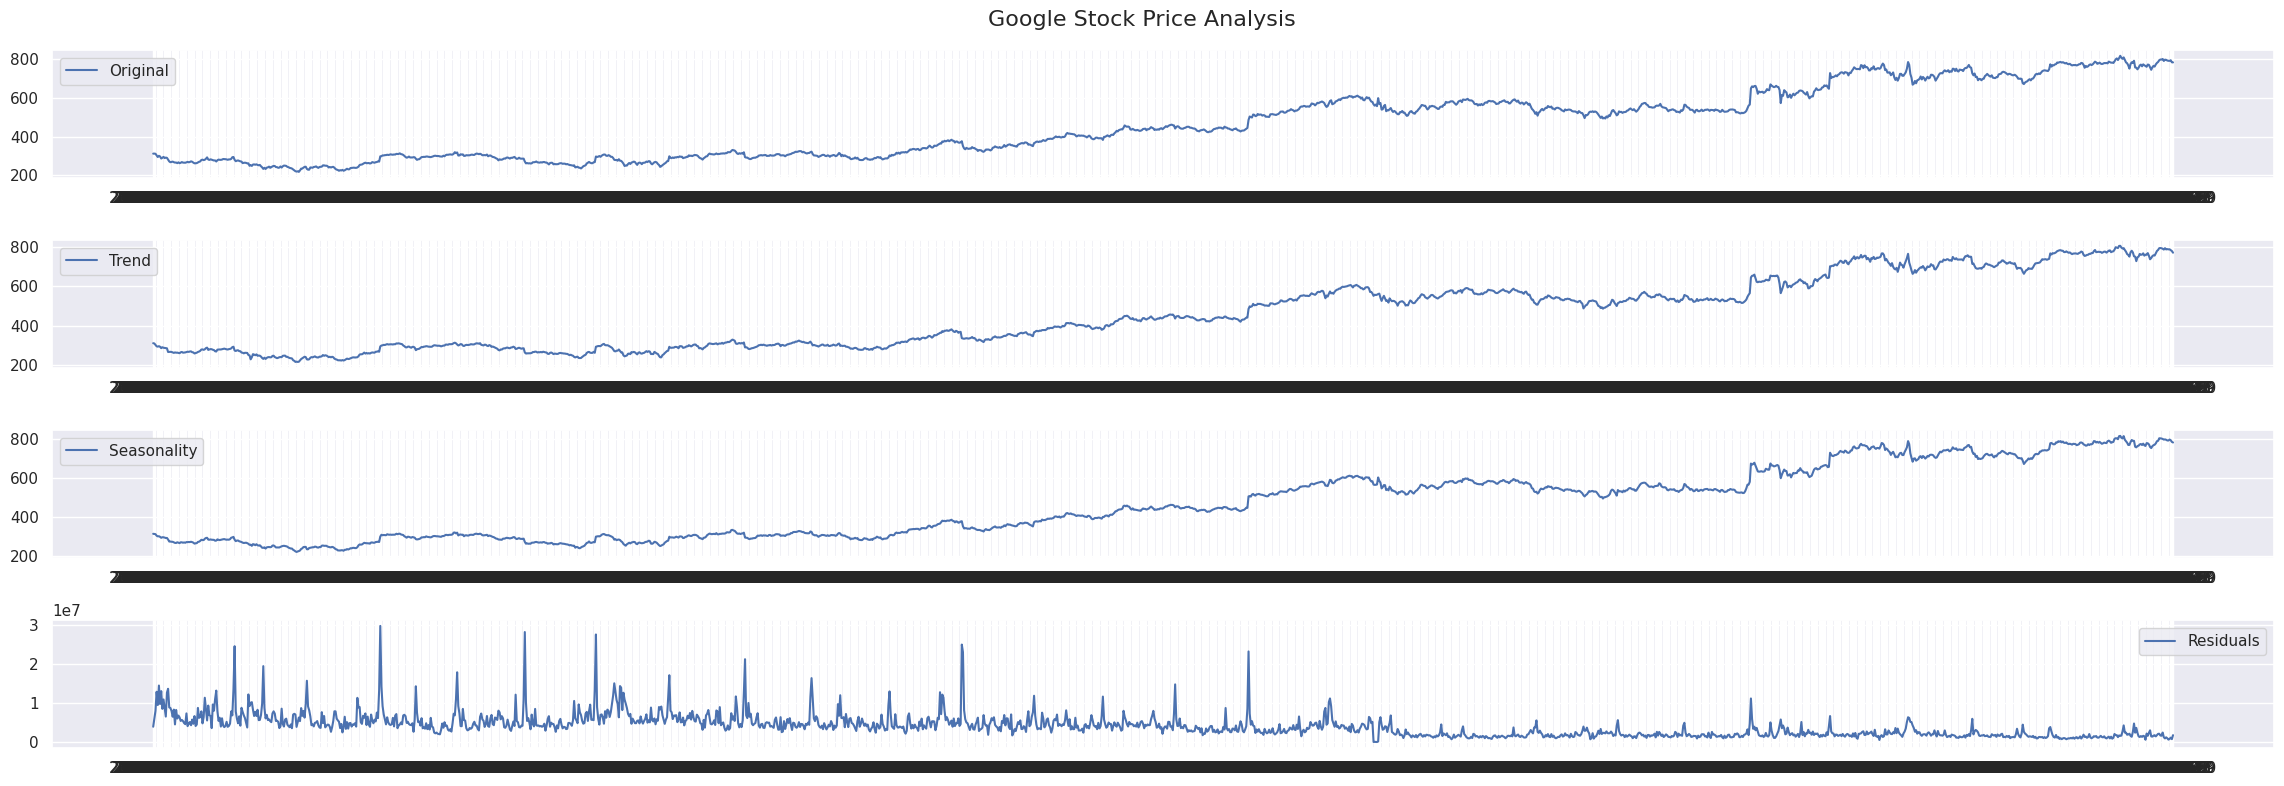

In [36]:
#plot attz para o novo padrão da biblioteca

fig = plt.figure(figsize=(23,8))

fig.suptitle("Google Stock Price Analysis", fontsize = 16) #análise de preços de ações do Google

ax1 = plt.subplot(411)
ax1.plot(df.open, label='Original')
ax1.legend(loc='best')

ax2 = plt.subplot(412)
ax2.plot(df.low, label='Trend')
ax2.legend(loc='best')

ax3 = plt.subplot(413)
ax3.plot(df.high,label='Seasonality')
ax3.legend(loc='best')

ax4 = plt.subplot(414)
ax4.plot(df.volume, label='Residuals')
ax4.legend(loc='best')

plt.tight_layout() #ajusta o espaçamento para n sobrepor
plt.show()

"\nax1 = plt.subplot(512)\nax1.plot(df.open, label='Original')\nax1.legend(loc='best')\n\nax2 = plt.subplot(513)\nax2.plot(df.low, label='Trend')\nax2.legend(loc='best')\n\nax3 = plt.subplot(514)\nax3.plot(df.high, label='Seasonality')\nax3.legend(loc='best')\n\nax4 = plt.subplot(515)\nax4.plot(df.volume, label='Residuals')\nax4.legend(loc='best')\n\nplt.tight_layout()\nplt.show()"

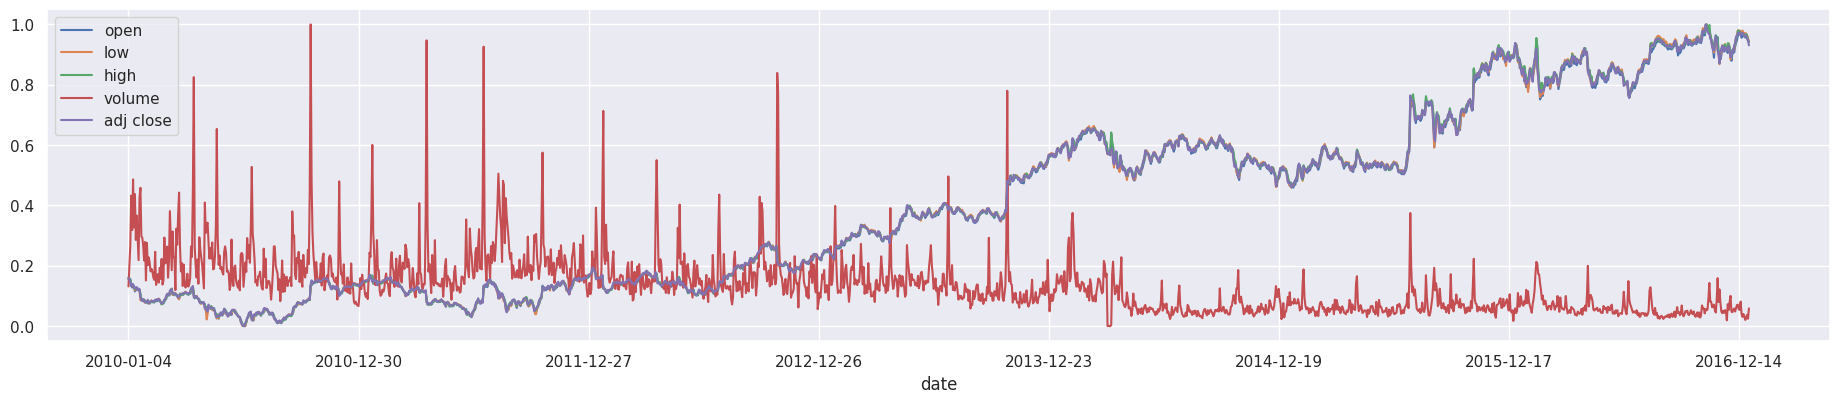

In [43]:
#normalizando os dados

def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)

#passou pelo mesmo processo de attz, pois a forma escrita pelo autor já não é compativel
  #new form bc author written form is not compatible with library

fig = plt.figure(figsize=(23,25))

ax0 = fig.add_subplot(511)
df.plot(ax=ax0)

#não parece ter nenhuma utilidade a priori
'''
ax1 = plt.subplot(512)
ax1.plot(df.open, label='Original')
ax1.legend(loc='best')

ax2 = plt.subplot(513)
ax2.plot(df.low, label='Trend')
ax2.legend(loc='best')

ax3 = plt.subplot(514)
ax3.plot(df.high, label='Seasonality')
ax3.legend(loc='best')

ax4 = plt.subplot(515)
ax4.plot(df.volume, label='Residuals')
ax4.legend(loc='best')

plt.tight_layout()
plt.show()'''


In [46]:
#função para preparar os dados (preprocess input data)
def load_data(stock, window):

    data = stock.to_numpy()
    result = []

    for index in range(len(data) - window): #maxmimum date = lastest date - sequence length
        result.append(data[index: index + window]) #index : index + n days

    print(np.array(result).shape)

    result = np.array(result).reshape(4*window, -1)
    row = round(0.9 * result.shape[1]) #90% treino + 10% teste (90% split)

    x_train = result[:, :int(row)]
    y_train = data[window:window+int(row),3].reshape(-1, 1)

    x_test = result[:, int(row):]
    y_test = data[window+int(row):,3].reshape(-1, 1)

    return [x_train, y_train, x_test, y_test]

In [47]:
x_train, y_train, x_test, y_test = load_data(df.iloc[:1760,:], 10)

(1750, 10, 5)


ValueError: cannot reshape array of size 87500 into shape (40,newaxis)